In [ ]:
file_name_train = 'train/DVH_Classification_CTDM_BLEED_ID0021.csv'
loaded_data = pd.read_csv(file_name_train,header=None,delimiter=",")

loaded_data.drop(loaded_data.index[0], inplace=True)
print(len(loaded_data))
loaded_data.drop_duplicates(inplace=True)
print(len(loaded_data))

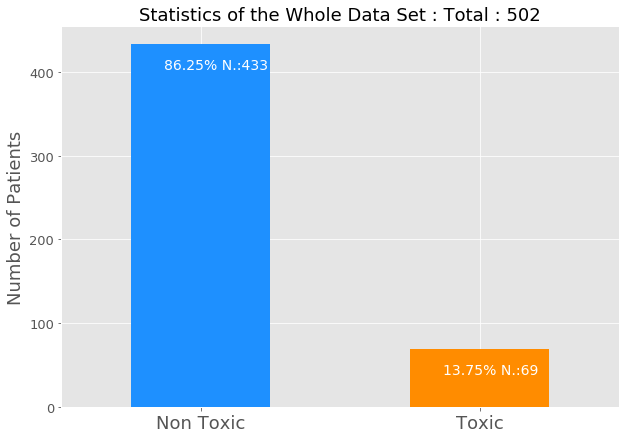

In [73]:
ax = total_df['T'].value_counts().plot(kind='bar', figsize=(10,7),
                                        color=['dodgerblue', 'darkorange'],fontsize=13);

ax.set_alpha(0.8)
ax.set_title("Statistics of the Whole Data Set : Total : 502", fontsize=18)
ax.set_ylabel("Number of Patients", fontsize=18);
ax.set_yticks([0, 100, 200, 300, 400])
ax.set_xticklabels(["Non Toxic","Toxic"], rotation=0, fontsize=18)
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.12, i.get_height()-30, \
            str(round((i.get_height()/total)*100, 2))+'% N.:' + str(i.get_height()), fontsize=14,
                color='white')

In [2]:
# loading libraries 
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE 

/Users/cyclops/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#fix random seed for reproducibility
seed = 7
np.random.seed(seed)
set_random_seed(seed)

In [4]:
#prepare dataset
def iterate_array(data_to_array):
    toxic = 0
    nontoxic = 0 
    data_ar = data_to_array.values
    #print(data_ar)
    for row in data_ar:
        if int(row) == 1 :
            toxic = toxic + 1
        if int(row) == 0 :
            nontoxic = nontoxic + 1
  
    return toxic,nontoxic
#training dataset
file_name_train = 'train/DVH_Classification_CTDM_BLEED_ID0021.csv'
loaded_data = pd.read_csv(file_name_train,header=None,delimiter=",")
features = loaded_data[:1:84]
features = features.drop(features.columns[0], axis=1)
features

loaded_data.drop(loaded_data.index[0], inplace=True)
loaded_data.sample(frac=1)

data_set_1_X = loaded_data.iloc[:,1:85].astype(float)
data_set_1_Y = loaded_data.iloc[:,0]

print('Size of the Data Set : ' , len(data_set_1_X))
tt_toxic,tt_nontoxic = iterate_array(data_set_1_Y)
print('Toxic: ' , tt_toxic, ' NonToxic: ' , tt_nontoxic)
print('Finished Loading')

Size of the Data Set :  502
Toxic:  69  NonToxic:  433
Finished Loading


In [5]:
def iterate_array(data_to_array):
    toxic = 0
    nontoxic = 0 
    for x in np.nditer(data_to_array):
        if x ==1 :
            toxic = toxic + 1
        if x == 0 :
            nontoxic = nontoxic + 1
    return toxic,nontoxic
# encode class values as integers
encoder_data = LabelEncoder()
encoder_data.fit(data_set_1_Y)
encoder_data_Y = encoder_data.transform(data_set_1_Y)

#default 70-30 separation 
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(data_set_1_X, encoder_data_Y, test_size=0.33, random_state=seed) 
print('Size of the training set: ' , len(train_X))
tt_toxic,tt_nontoxic = iterate_array(train_Y)
print('Toxic: ' , tt_toxic, ' Non Toxic: ' , tt_nontoxic)
print('Size of the testing set: ',len(test_X))
tr_toxic,tr_nontoxic = iterate_array(test_Y)
print('Toxic: ' , tr_toxic, ' Non Toxic: ' , tr_nontoxic)

Size of the training set:  336
Toxic:  47  Non Toxic:  289
Size of the testing set:  166
Toxic:  22  Non Toxic:  144


In [6]:
#SMOTE OVERSAMPLING
from collections import Counter
sm = SMOTE(random_state=42,ratio={1:200})
X_train, Y_train = sm.fit_sample(train_X, train_Y)
print('Resampled dataset shape {}'.format(Counter(Y_train)))

Resampled dataset shape Counter({0: 289, 1: 200})


In [17]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(encoder_data_Y),
                                                 encoder_data_Y)
print(class_weights)

[0.57967667 3.63768116]


In [22]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=123456, verbose=0,
            warm_start=False)

In [23]:
from sklearn.metrics import accuracy_score
#print(encoded_Y)
encoder_test = LabelEncoder()
encoder_test.fit(test_Y)
encoded_test_Y = encoder_test.transform(test_Y)

predicted = rf.predict(test_X)
accuracy = accuracy_score(encoded_test_Y, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
cm = confusion_matrix(encoded_test_Y, predicted.round())
print(cm)

Out-of-bag score estimate: 0.843
Mean accuracy score: 0.831
[[134  10]
 [ 18   4]]


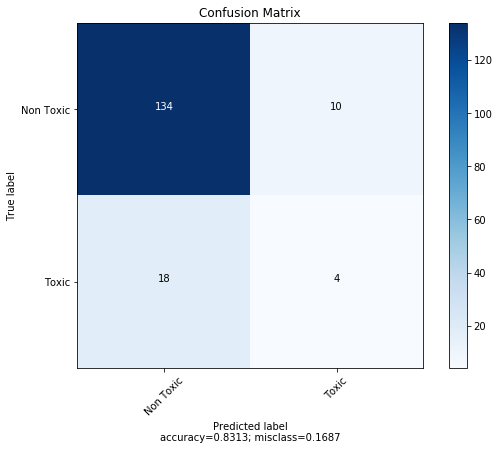

In [12]:
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['Non Toxic', 'Toxic'],
                      title        = "Confusion Matrix")

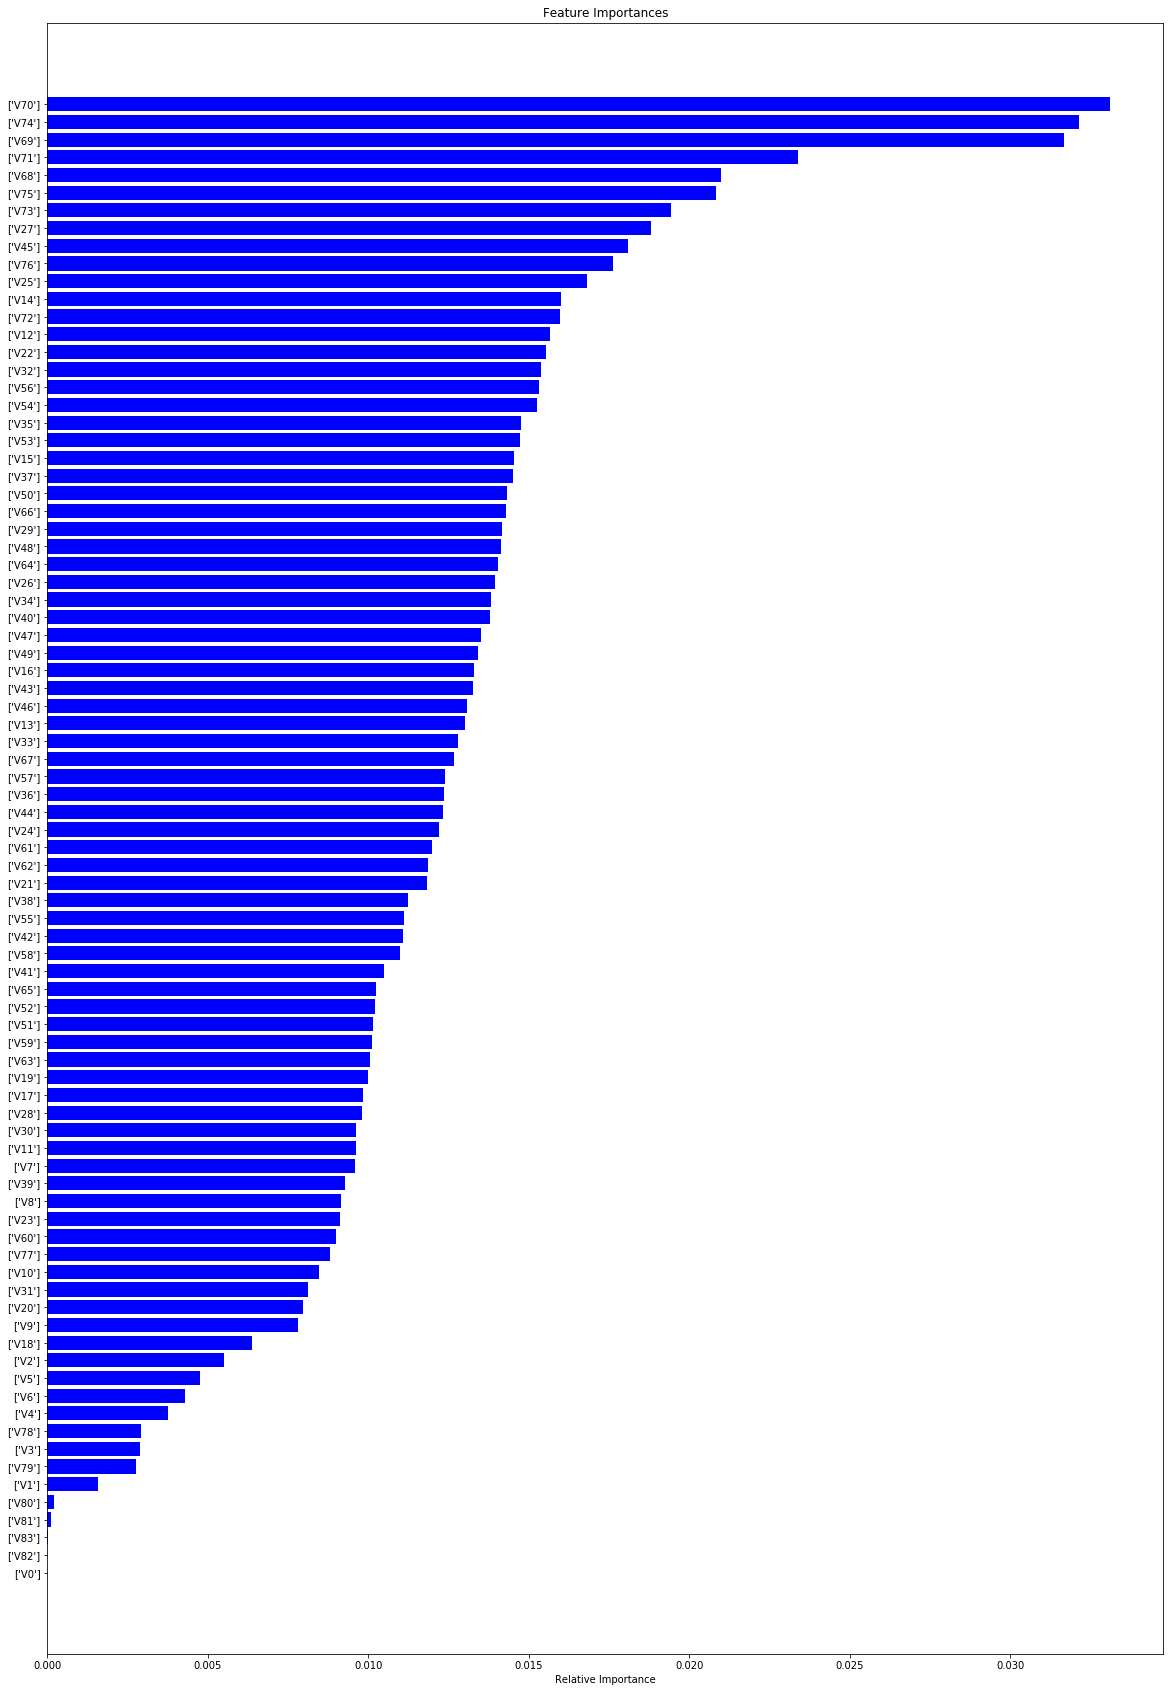

In [10]:
importances = rf.feature_importances_
indices = np.argsort(importances)
feature_list =[]
for column_name, column in features.transpose().iterrows():
    feature_list.append(column.values)    
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(feature_list)[indices])
plt.xlabel('Relative Importance')
plt.show()

In [9]:
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 20
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size

Current size: [6.0, 4.0]


ROC AUC: 0.58


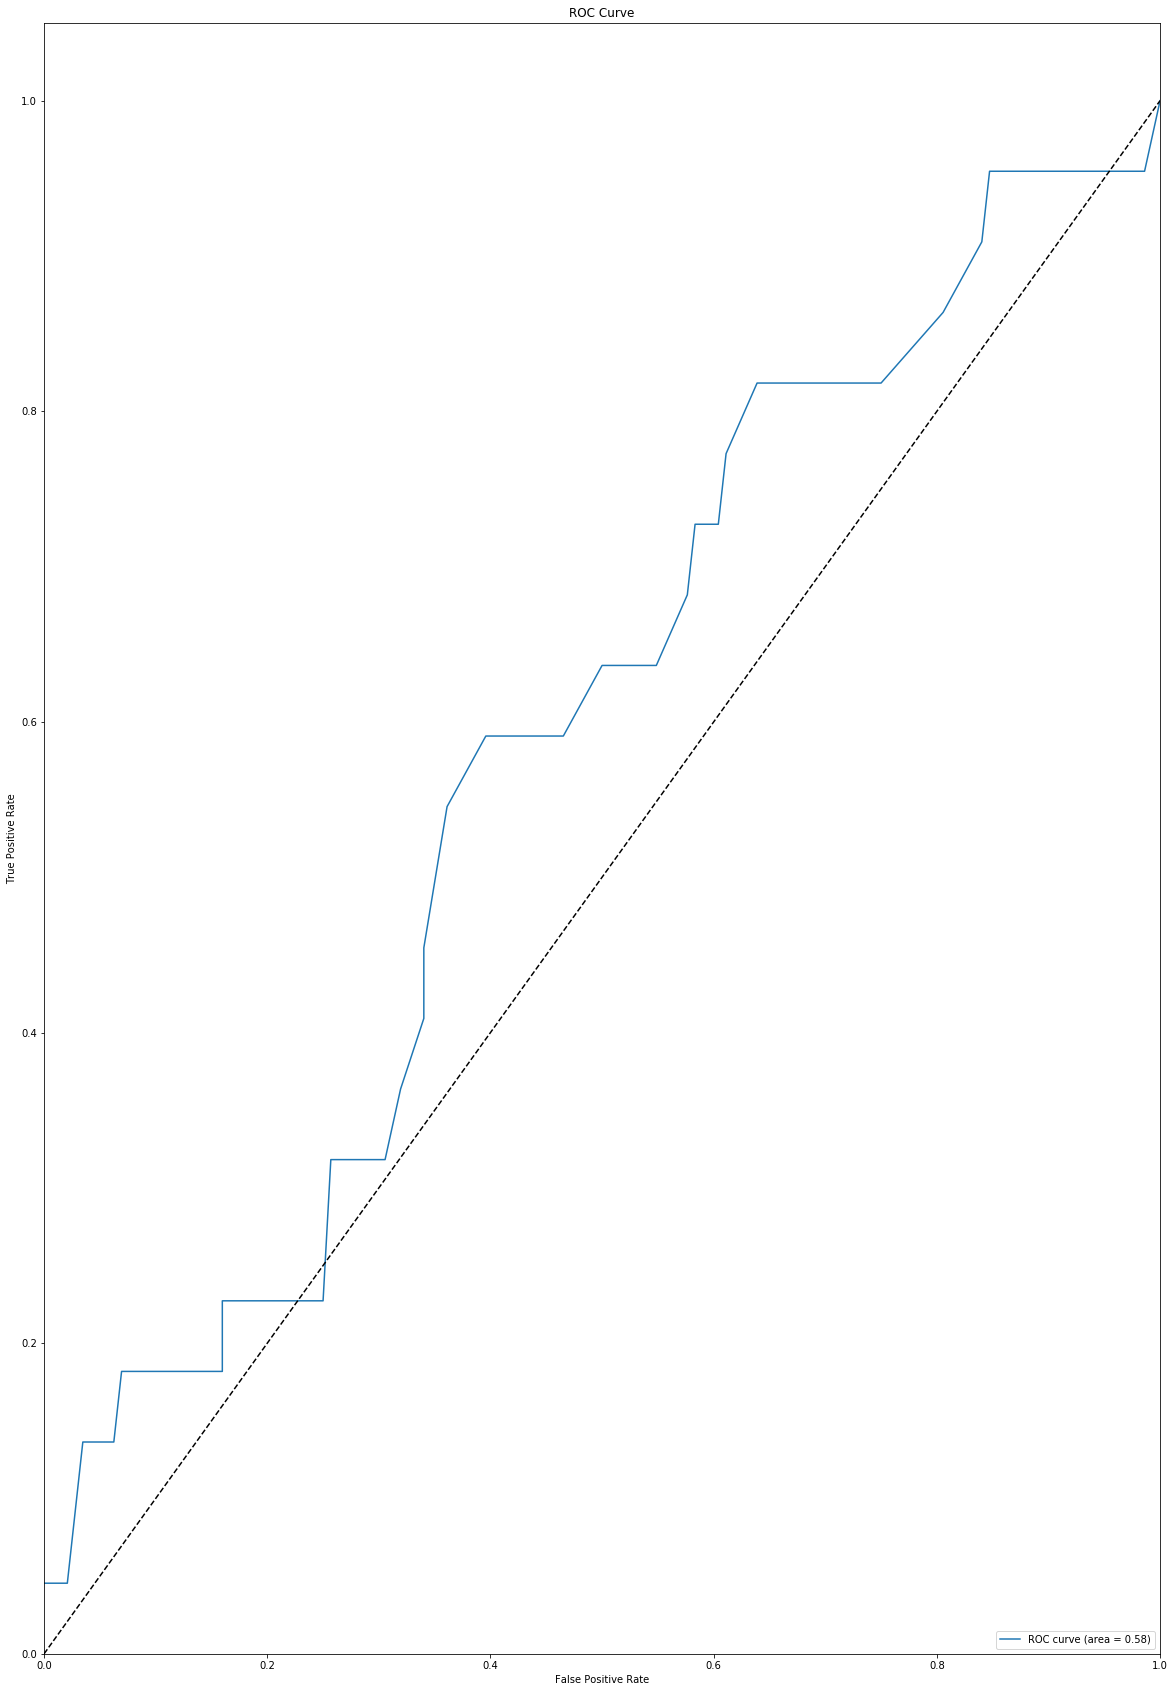

In [13]:
#plotting ROC Curve
from sklearn.metrics import roc_curve, auc

# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(encoded_test_Y, rf.predict_proba(test_X)[:,1])

# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC: %0.2f' % roc_auc)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [36]:
indices

array([ 0, 82, 83, 81, 80,  1, 79,  3, 78,  4,  6,  5,  2, 18,  9, 20, 31,
       10, 77, 60, 23,  8, 39,  7, 11, 30, 28, 17, 19, 63, 59, 51, 52, 65,
       41, 58, 42, 55, 38, 21, 62, 61, 24, 44, 36, 57, 67, 33, 13, 46, 43,
       16, 49, 47, 40, 34, 26, 64, 48, 29, 66, 50, 37, 15, 53, 35, 54, 56,
       32, 22, 12, 72, 14, 25, 76, 45, 27, 73, 75, 68, 71, 69, 74, 70])

In [11]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
   
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [34]:
np.array(feature_list)[indices]

array([['V0'],
       ['V82'],
       ['V83'],
       ['V81'],
       ['V80'],
       ['V1'],
       ['V79'],
       ['V3'],
       ['V78'],
       ['V4'],
       ['V6'],
       ['V5'],
       ['V2'],
       ['V18'],
       ['V9'],
       ['V20'],
       ['V31'],
       ['V10'],
       ['V77'],
       ['V60'],
       ['V23'],
       ['V8'],
       ['V39'],
       ['V7'],
       ['V11'],
       ['V30'],
       ['V28'],
       ['V17'],
       ['V19'],
       ['V63'],
       ['V59'],
       ['V51'],
       ['V52'],
       ['V65'],
       ['V41'],
       ['V58'],
       ['V42'],
       ['V55'],
       ['V38'],
       ['V21'],
       ['V62'],
       ['V61'],
       ['V24'],
       ['V44'],
       ['V36'],
       ['V57'],
       ['V67'],
       ['V33'],
       ['V13'],
       ['V46'],
       ['V43'],
       ['V16'],
       ['V49'],
       ['V47'],
       ['V40'],
       ['V34'],
       ['V26'],
       ['V64'],
       ['V48'],
       ['V29'],
       ['V66'],
       ['V50'],
       ['V37'],
  

In [108]:


toxic,nontoxic = iterate_array(test_Y)
print(toxic)
print(nontoxic)

22
144


In [87]:


data =[1,2,3,4,5,6]
tt_toxic,tt_nontoxic = iterate_array(data_set_1_Y)
print(tt_toxic,tt_nontoxic)

69 433


In [25]:
file_name_test= 'train/RectqlTOxData.csv'
test_df = pd.read_csv(file_name_test,sep=';')
test_df.columns = test_df.columns.str.replace('\s+', '')
test_X = test_df.iloc[:,1:85].astype(float)
#test_Y = test_df.iloc[:,0] 

toxic_counter_test = 0 
nontox_counter_test = 0
for i, row in test_df.iterrows():
    if row['T'] == 1:
        toxic_counter_test = toxic_counter_test + 1
    if row['T'] == 0 :
        nontox_counter_test = nontox_counter_test + 1
print(toxic_counter_test)
print(nontox_counter_test)

12
51


In [30]:
def iterate_array_df(data_to_array):
    toxic = 0
    nontoxic = 0 
    for x in data_to_array:
        if x == 1 :
            toxic = toxic + 1
        if x == 0 :
            nontoxic = nontoxic + 1
    return toxic,nontoxic
def iterate_array(data_to_array):
    toxic = 0
    nontoxic = 0 
    for x in np.nditer(data_to_array):
        if x ==1 :
            toxic = toxic + 1
        if x == 0 :
            nontoxic = nontoxic + 1
    return toxic,nontoxic

In [43]:
#prepare dataset
#training dataset
file_name_train = 'train/DVH_Classification_CTDM_BLEED_ID0021.csv'
loaded_data = pd.read_csv(file_name_train,header=None,delimiter=",")

#create feature list
features = loaded_data[:1:84]
features = features.drop(features.columns[0], axis=1)

loaded_data.drop(loaded_data.index[0], inplace=True)
loaded_data.sample(frac=1)
train_X = loaded_data.iloc[:,1:85].astype(float)
train_Y = loaded_data.iloc[:,0]
#train_X
#train_Y

#testing set
file_name_test= 'train/RectqlTOxData.csv'
test_df = pd.read_csv(file_name_test,sep=';')
test_df.columns = test_df.columns.str.replace('\s+', '')
test_X = test_df.iloc[:,1:85].astype(float)
test_Y = test_df.iloc[:,0] 
# encode class values as integers
encoder_train = LabelEncoder()
encoder_train.fit(train_Y)
encoded_train_Y = encoder_train.transform(train_Y)
#print(encoded_Y)
encoder_test = LabelEncoder()
encoder_test.fit(test_Y)
encoded_test_Y = encoder_test.transform(test_Y)

print('Size of the training Set: ' , len(encoded_train_Y))
tt_toxic,tt_nontoxic = iterate_array_nor(encoded_train_Y)
print('Toxic: ' , tt_toxic, ' NonToxic: ' , tt_nontoxic)
print('Size of the testing Set: ' , len(encoded_test_Y))
tr_toxic,tr_nontoxic = iterate_array_nor(encoded_test_Y)
print('Toxic: ' , tr_toxic, ' NonToxic: ' , tr_nontoxic)


        0        1        2         3         4         5         6         7  \
0   100.0    100.0    100.0    100.00     99.25  98271.00  97412.00  96789.00   
1   100.0    100.0    100.0    100.00  99964.00  99802.00  99511.00  99177.00   
2   100.0  99998.0  99997.0  99995.00  99993.00  99813.00  99619.00  99072.00   
3   100.0  99999.0  99998.0  99997.00  99996.00  99995.00  99994.00  99993.00   
4   100.0    100.0    100.0  99403.00  97815.00  96635.00  95806.00  95213.00   
5   100.0    100.0    100.0  99727.00  98088.00  96785.00  95741.00  95118.00   
6   100.0    100.0    100.0    100.00  99981.00  98984.00     98.14  97558.00   
7   100.0    100.0    100.0    100.00  98688.00  97676.00  97195.00  96515.00   
8   100.0    100.0    100.0    100.00  99882.00  99031.00  98437.00  98121.00   
9   100.0    100.0    100.0    100.00    100.00    100.00    100.00    100.00   
10  100.0  99998.0  99997.0  99995.00  99993.00     99.87  99327.00  98967.00   
11  100.0    100.0    100.0 

In [ ]:
total_df = pd.concat([train_df, test_df])

In [68]:
def iterate_array_df(data_to_array):
    toxic = 0
    nontoxic = 0 
    for x in data_to_array:
        if x == 1 :
            toxic = toxic + 1
        if x == 0 :
            nontoxic = nontoxic + 1
    return toxic,nontoxic
#prepare dataset
#training dataset
file_name_train = 'train/DVH_Classification_CTDM_BLEED_ID0021.csv'
data_set_1 = pd.read_csv(file_name_train,header=None,delimiter=",")

#create feature list
features = data_set_1[:1:84]
features = features.drop(features.columns[0], axis=1)

data_set_1.drop(data_set_1.index[0], inplace=True)
data_set_1.sample(frac=1)

data_set_1_X = data_set_1.iloc[:,1:85].astype(float)
data_set_1_Y = data_set_1.iloc[:,0]

print('Size of the Data Set-1 : ' , len(data_set_1_Y))
tt_toxic,tt_nontoxic = iterate_array_df(encoded_train_Y)
print('Toxic: ' , tt_toxic, ' NonToxic: ' , tt_nontoxic)
print('Finished Loading Set-1')

Size of the Data Set-1 :  502
Toxic:  57  NonToxic:  382
Finished Loading Set-1


In [61]:
def iterate_array(data_to_array):
    toxic = 0
    nontoxic = 0 
    for x in np.nditer(data_to_array):
        if x ==1 :
            toxic = toxic + 1
        if x == 0 :
            nontoxic = nontoxic + 1
    return toxic,nontoxic

file_name_test= 'train/RectqlTOxData.csv'
data_set_2 = pd.read_csv(file_name_test,sep=';')
data_set_2.columns = data_set_2.columns.str.replace('\s+', '')
data_set_2.sample(frac=1)

data_set_2_X = data_set_2.iloc[:,1:85].astype(float)
data_set_2_Y = data_set_2.iloc[:,91]
print(type(data_set_2_Y))

print('Size of the Data Set-2 : ' , len(data_set_2_Y))
tt_toxic,tt_nontoxic = iterate_array(data_set_2_Y)
print('Toxic: ' , tt_toxic, ' NonToxic: ' , tt_nontoxic)
print('Finished Loading Set-2')


<class 'pandas.core.series.Series'>
Size of the Data Set-2 :  63
Toxic:  12  NonToxic:  51
Finished Loading Set-2


In [5]:

total_df = pd.concat([train_df, test_df])


train_X = loaded_data.iloc[:,1:85].astype(float)
train_Y = loaded_data.iloc[:,0]
#train_X
#train_Y

#testing set
file_name_test= 'train/RectqlTOxData.csv'
test_df = pd.read_csv(file_name_test,sep=';')
test_df.columns = test_df.columns.str.replace('\s+', '')
test_X = test_df.iloc[:,1:85].astype(float)
test_Y = test_df.iloc[:,0] 

# encode class values as integers
encoder_train = LabelEncoder()
encoder_train.fit(train_Y)
encoded_train_Y = encoder_train.transform(train_Y)
#print(encoded_Y)
encoder_test = LabelEncoder()
encoder_test.fit(test_Y)
encoded_test_Y = encoder_test.transform(test_Y)

#compute class weight 
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(encoded_Y),
                                                 encoded_Y)
print(class_weights)

[0.57460733 3.85087719]


In [18]:
#default 80-30 separation 
X_res, X_test, Y_res, Y_test = model_selection.train_test_split(train_X, encoded_train_Y, test_size=0.33, random_state=seed) 
print('Size of the training set: ' , len(X_res))
print('Size of the testing set: ',len(X_test))


Size of the training set:  294
Size of the testing set:  145


In [56]:
print(len(X_train))

682


In [45]:
importances = rf.feature_importances_
indices = np.argsort(importances)

In [22]:
#model prepartion 
#model = create_model() 
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(84, input_dim=84, kernel_initializer='normal', activation='relu'))
model.add(Dense(84, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(42, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(11, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.summary() 
sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy']) 
class_weight = {0:0.57460733,1:3.85087719}
model.fit(X_train,Y_train,epochs=300, batch_size=10, verbose=1)#,class_weight=class_weights)
#built_model = model.fit(np.array(train_X),np.array(encoded_Y), validation_split=0.33, epochs=2000, batch_size=10, verbose=1)
predictions = model.predict(np.array(X_train))
cm = confusion_matrix((np.array(Y_train)), predictions.round())
print(cm)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 84)                7140      
_________________________________________________________________
dense_22 (Dense)             (None, 84)                7140      
_________________________________________________________________
dropout_13 (Dropout)         (None, 84)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 42)                3570      
_________________________________________________________________
dropout_14 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 11)                473       
_________________________________________________________________
dropout_15 (Dropout)         (None, 11)                0         
__________

In [9]:
from sklearn.metrics import recall_score
balanced_accuracy = recall_score(Y_train,predictions.round(), average='macro')
print('Balanced Accuracy: ' , balanced_accuracy)

Balanced Accuracy:  0.5


In [43]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, predicted.round(), target_names=target_names))


             precision    recall  f1-score   support

    class 0       0.91      0.88      0.90       132
    class 1       0.11      0.15      0.13        13

avg / total       0.84      0.81      0.83       145



In [104]:
import math
print('----------Data Statistics----------')
print('\n')
file_name_test= 'train/RectqlTOxData.csv'
test_df = pd.read_csv(file_name_test,sep=';')
test_df.columns = test_df.columns.str.replace('\s+', '')
toxic_tt,nontoxic_tt = get_t_stat(test_df)
print('Testing Set: ' , len(test_df))
print('Toxic : ' , toxic_tt,'  Non-Toxic : ' , nontoxic_tt)
test_percentage = pd.DataFrame({'Percentage': test_df.groupby(('T')).size() / len(test_df)})
print(test_percentage)


file_name_train = 'train/DVH_Classification_CTDM_BLEED_ID0021.csv'
train_df = pd.read_csv(file_name_train)
toxic_tr,nontoxic_tr = get_t_stat(train_df)
print('Training Set: ' , len(train_df))
print('Toxic : ' , toxic_tr , '  Non-Toxic : ' , nontoxic_tr)
train_percentage = pd.DataFrame({'Percentage': train_df.groupby(('T')).size() / len(train_df)})
print(train_percentage)

total_toxic = toxic_tt + toxic_tr
total_nontoxic = nontoxic_tt + nontoxic_tr

print('\n\n')
print('Total Toxic: ' , total_toxic)
print('Total Non-Toxic: ' , total_nontoxic)

----------Data Statistics----------


Testing Set:  63
Toxic :  12   Non-Toxic :  51
   Percentage
T            
0    0.809524
1    0.190476
Training Set:  439
Toxic :  57   Non-Toxic :  382
   Percentage
T            
0    0.870159
1    0.129841



Total Toxic:  69
Total Non-Toxic:  433


In [12]:
print('----------Data Statistics for Training/Testing Set ----------')
print('\n')
toxic_tt,nontoxic_tt = iterate_array(Y_train)
print('Training Set: ' , len(X_train))
print('Toxic : ' , toxic_tt,'  Non-Toxic : ' , nontoxic_tt)


toxic_tr,nontoxic_tr = iterate_array(Y_test)
print('Testing Set: ' , len(X_test))
print('Toxic : ' , toxic_tr , '  Non-Toxic : ' , nontoxic_tr)


total_toxic = toxic_tt + toxic_tr
total_nontoxic = nontoxic_tt + nontoxic_tr

print('\n\n')
print('Total Toxic: ' , total_toxic)
print('Total Non-Toxic: ' , total_nontoxic)

----------Data Statistics for Training/Testing Set ----------


Training Set:  294
Toxic :  44   Non-Toxic :  250
Testing Set:  145
Toxic :  13   Non-Toxic :  132



Total Toxic:  57
Total Non-Toxic:  382


In [3]:
#training set
file_name_train= 'train/DVH_Classification_CTDM_BLEED_ID0021.csv'
train_df = pd.read_csv(file_name_train,sep=',')
train_df.columns = train_df.columns.str.replace('\s+', '')

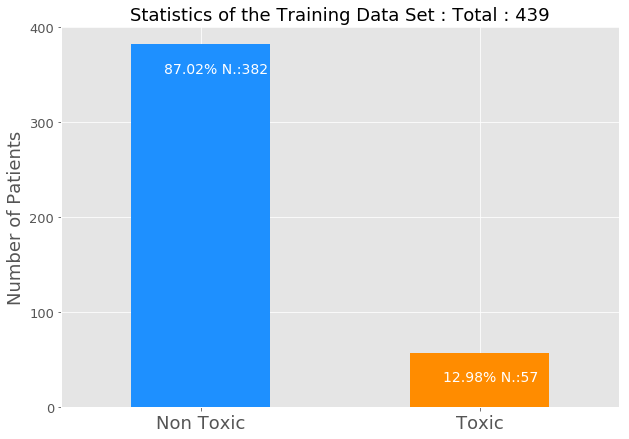

In [68]:

ax = train_df['T'].value_counts().plot(kind='bar', figsize=(10,7),
                                        color=['dodgerblue', 'darkorange'],fontsize=13);

ax.set_alpha(0.8)
ax.set_title("Statistics of the Training Data Set : Total : 439", fontsize=18)
ax.set_ylabel("Number of Patients", fontsize=18);
ax.set_yticks([0, 100, 200, 300, 400])
ax.set_xticklabels(["Non Toxic","Toxic"], rotation=0, fontsize=18)
#ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#ax.legend(loc='upper right', frameon=False)
#ax.set_xticklabels(["Toxic"], rotation=90, fontsize=11)
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.12, i.get_height()-30, \
            str(round((i.get_height()/total)*100, 2))+'% N.:' + str(i.get_height()), fontsize=14,
                color='white')


In [65]:
#testing set
file_name_test= 'train/RectqlTOxData.csv'
test_df = pd.read_csv(file_name_test,sep=';')
test_df.columns = test_df.columns.str.replace('\s+', '')


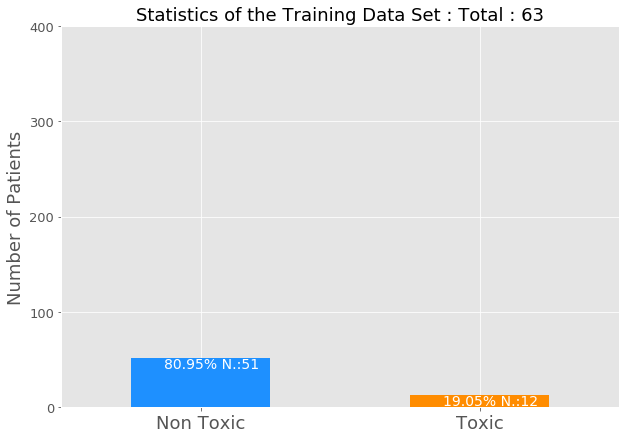

In [70]:
ax = test_df['T'].value_counts().plot(kind='bar', figsize=(10,7),
                                        color=['dodgerblue', 'darkorange'],fontsize=13);

ax.set_alpha(0.8)
ax.set_title("Statistics of the Testing Data Set : Total : 63", fontsize=18)
ax.set_ylabel("Number of Patients", fontsize=18);
ax.set_yticks([0, 100, 200, 300, 400])
ax.set_xticklabels(["Non Toxic","Toxic"], rotation=0, fontsize=18)
#ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#ax.legend(loc='upper right', frameon=False)
#ax.set_xticklabels(["Toxic"], rotation=90, fontsize=11)
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.12, i.get_height()-10, \
            str(round((i.get_height()/total)*100, 2))+'% N.:' + str(i.get_height()), fontsize=14,
                color='white')

In [71]:
total_df = pd.concat([train_df, test_df])


In [32]:
without_na = process_df.dropna()
without_na['T'] = without_na['T'].astype(int)
without_na

without_na.to_csv('test.csv', index=False)

#print column
#print(test_df.columns.tolist())
#removing white space from the header
test_df.columns = test_df.columns.str.replace('\s+', '')
#train_df
print(len(test_df['T'] == 0))

toxic_counter_test = 0 
nontox_counter_test = 0
for i, row in test_df.iterrows():
    if row['T'] == 1:
        toxic_counter_test = toxic_counter_test + 1
    if row['T'] == 0 :
        nontox_counter_test = nontox_counter_test + 1
        

print(toxic_counter_test)
print(nontox_counter_test)
value = float((12/63)*100)
value
result = pd.DataFrame({'Percentage': test_df.groupby(('T')).size() / len(test_df)})
print(result)


import numpy as np
import pandas as pd
main = [1,2,3,4,5,6,7,8,9,10]
t1 = main[1:10]
t2 = main[0]

dataset = pd.DataFrame(np.random.rand(5, 5))
y=dataset.iloc[:, 0]
X=dataset.iloc[:, 1:5]


print(dataset)
print(X)
print(y)
def create_model():
    model = Sequential()
    model.add(Dense(84, input_dim=84, kernel_initializer='normal', activation='relu'))
    model.add(Dense(84, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(84, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    return model

toxic , nontoxic = iterate_array(Y_train)
print(toxic)
print(nontoxic)

toxic,nontoxic = iterate_array(encoded_Y)
print(toxic)
print(nontoxic)
print(len(Y))

/Users/cyclops/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,T,V0,V1,V2,V3,V4,V5,V6,V7,V8,...,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83
7,1,100.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,3.32,1.07,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
8,0,100.0,100.00,100.00,100.00,100.00,99.95,99.33,98.60,97.82,...,9.03,4.87,1.03,0.01,0.00,0.00,0.0,0.0,0.0,0.0
9,0,100.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
10,0,100.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
13,0,100.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,9.87,7.09,3.21,0.00,0.00,0.00,0.0,0.0,0.0,0.0
17,0,100.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,8.89,4.29,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
20,1,100.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
24,1,100.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,98.79,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
25,0,100.0,100.00,100.00,100.00,100.00,99.95,99.32,98.26,97.20,...,2.45,1.44,0.68,0.27,0.10,0.01,0.0,0.0,0.0,0.0
27,0,100.0,100.00,100.00,100.00,100.00,100.00,99.99,99.68,98.81,...,2.41,1.41,0.33,0.03,0.00,0.00,0.0,0.0,0.0,0.0


In [68]:
def get_t_stat(dataframe):
    toxic_counter = 0
    nontox_counter = 0
    for i, row in dataframe.iterrows():
        if row['T'] == 1:
            toxic_counter = toxic_counter + 1
        if row['T'] == 0 :
            nontox_counter = nontox_counter + 1
    return toxic_counter,nontox_counter
        

def iterate_array(data_to_array):
    toxic = 0
    nontoxic = 0 
    for x in np.nditer(data_to_array):
        if x ==1 :
            toxic = toxic + 1
        if x == 0 :
            nontoxic = nontoxic + 1
    return toxic,nontoxic

def iterate_array_nor(data_to_array):
    toxic = 0
    nontoxic = 0 
    for x in data_to_array:
        if x ==1 :
            toxic = toxic + 1
        if x == 0 :
            nontoxic = nontoxic + 1
    return toxic,nontoxic

In [3]:
# Baseline Model on the Sonar Dataset
import numpy
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.optimizers import SGD
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset
dataframe = read_csv("sonar.csv", header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

/Users/cyclops/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
# baseline
def create_baseline():
    # create model
	model = Sequential()
	model.add(Dense(60, input_dim=60, kernel_initializer='normal', activation='relu'))
	model.add(Dense(30, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
	# Compile model
	sgd = SGD(lr=0.01, momentum=0.8, decay=0.0, nesterov=False)
	model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
	return model


In [9]:
model = create_baseline()
model.fit(X,encoded_Y,epochs=300, batch_size=16, verbose=1)


Epoch 1/300
208/208 [==============================] - 0s - loss: 0.6935 - acc: 0.4615     
Epoch 2/300
208/208 [==============================] - 0s - loss: 0.6927 - acc: 0.5337     
Epoch 3/300
208/208 [==============================] - 0s - loss: 0.6923 - acc: 0.5337     
Epoch 4/300
208/208 [==============================] - 0s - loss: 0.6918 - acc: 0.5337     
Epoch 5/300
208/208 [==============================] - 0s - loss: 0.6915 - acc: 0.5337     
Epoch 6/300
208/208 [==============================] - 0s - loss: 0.6911 - acc: 0.5337     
Epoch 7/300
208/208 [==============================] - 0s - loss: 0.6913 - acc: 0.5337     
Epoch 8/300
208/208 [==============================] - 0s - loss: 0.6910 - acc: 0.5337     
Epoch 9/300
208/208 [==============================] - 0s - loss: 0.6909 - acc: 0.5337     
Epoch 10/300
208/208 [==============================] - 0s - loss: 0.6908 - acc: 0.5337     
Epoch 11/300
208/208 [==============================] - 0s - loss: 0.6907 - acc

In [13]:
#built_model = model.fit(np.array(train_X),np.array(encoded_Y), validation_split=0.33, epochs=2000, batch_size=10, verbose=1)
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.metrics import confusion_matrix

predictions = model.predict(np.array(X))
cm = confusion_matrix((np.array(encoded_Y)), predictions.round())
print(cm)

[[110   1]
 [  0  97]]


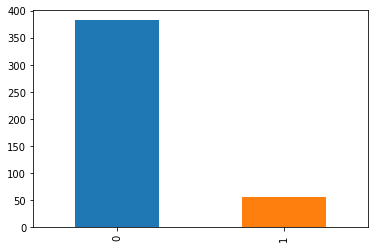

In [5]:
train_df['T'].value_counts().plot(kind='bar')

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [42]:
lines = ax.get_lines()
lines

<a list of 0 Line2D objects>

In [20]:
train_df['T'].value_counts()

0    382
1     57
Name: T, dtype: int64

In [ ]:
colors = pd.tools.plotting._get_standard_colors(len(groups), color_type='random')

fig, ax = plt.subplots()
ax.set_color_cycle(colors)
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend(numpoints=1, loc='upper left')

plt.show()

In [48]:
groups = test_df.groupby('T')
# Plot
#plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)


In [49]:
groups.count()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83
T,,,,,,,,,,,,,,,,,,,,,
0,382,382,382,382,382,382,382,382,382,382,...,382,382,382,382,382,382,382,382,382,382
1,57,57,57,57,57,57,57,57,57,57,...,57,57,57,57,57,57,57,57,57,57


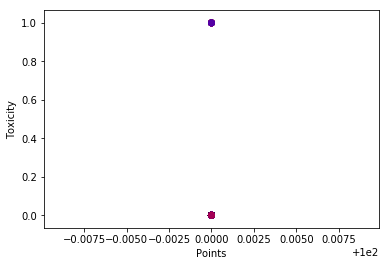

In [51]:
color = ['r','b']
plt.scatter(test_df['V0'],test_df['T'], alpha=0.2,
             c=color, cmap='viridis')

plt.xlabel('Points')
plt.ylabel('Toxicity')
plt.show()

In [43]:
for key, item in groups:
    print(groups.get_group(key))
    sns.lmplot(item.V0, # Horizontal axis
           item.T, # Vertical axis
           data=df, # Data source
           fit_reg=False, # Don't fix a regression line
           hue="z", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size

     T     V0      V1      V2      V3      V4      V5      V6      V7      V8  \
1    0  100.0  100.00  100.00  100.00  100.00   99.95   99.33   98.60   97.82   
2    0  100.0  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00   
3    0  100.0  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00   
4    0  100.0  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00   
5    0  100.0  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00   
8    0  100.0  100.00  100.00  100.00  100.00   99.95   99.32   98.26   97.20   
9    0  100.0  100.00  100.00  100.00  100.00  100.00   99.99   99.68   98.81   
10   0  100.0  100.00  100.00  100.00  100.00  100.00  100.00  100.00   98.90   
11   0  100.0  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00   
12   0  100.0  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00   
13   0  100.0  100.00  100.00  100.00   98.29   96.66   92.26   88.80   87.33   
15   0  100.0  100.00   99.9

In [31]:
test_df['T']

0      1
1      0
2      0
3      0
4      0
5      0
6      1
7      1
8      0
9      0
10     0
11     0
12     0
13     0
14     1
15     0
16     0
17     1
18     0
19     0
20     0
21     0
22     0
23     0
24     1
25     1
26     0
27     0
28     0
29     0
      ..
409    0
410    0
411    0
412    1
413    0
414    0
415    0
416    0
417    0
418    0
419    0
420    0
421    0
422    0
423    0
424    0
425    0
426    0
427    0
428    0
429    0
430    0
431    0
432    0
433    0
434    0
435    0
436    0
437    1
438    0
Name: T, Length: 439, dtype: int64